# Introduction
Check the [pdf report](https://github.com/DavideEspositoPelella/Anomaly_Detection-GAN_Based.git/Report) or the [GitHub repository](https://github.com/DavideEspositoPelella/Anomaly_Detection_GAN_Based.git).

The following Colab notebook represent the implementation of the Deep Learning project _**GAN-based Anomaly Detection in Imbalance Problems**_.

<a href="https://colab.research.google.com/drive/1XKohwPFibuQDeruwHoRtRP4fjYGqGN3M?usp=drive_link"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="google colab logo" height=30px></a>


# Imports
Importing all the libraries and dependencies needed

In [ ]:
! pip install --quiet "pytorch-lightning"
! pip install --quiet gdown

In [ ]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.cluster import KMeans
import platform
import random

print("Lightning version:", pl.__version__)
print("PyTorch version:", torch.__version__)
print("Python version:", platform.python_version())


Lightning version: 2.0.7
PyTorch version: 2.0.1+cu118
Python version: 3.10.12


In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# Dataset and Preprocessing

In [ ]:
# Randomly rotate the images by 90, 180, or 270 degrees
class Rotation3:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        img = T.functional.rotate(img, angle)
        return img

# DataModule
class AnomalyDetectionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, subsampling, subsamples, normal_class, data_dir="./"):
        super().__init__()

        self.normal_class = normal_class
        self.subsampling = subsampling
        self.subsamples = subsamples

        self.train_transform = T.Compose([
            T.Resize(32),
            T.RandomVerticalFlip(),
            T.RandomHorizontalFlip(),
            T.RandomCrop(30),
            T.Resize(32),
            T.Grayscale(1),  # Use 1 channel (grayscale)
            T.RandomApply([Rotation3()], p=1),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])
        self.test_transform = T.Compose([
            T.Resize(32),
            T.Grayscale(1),  # Use 1 channel (grayscale)
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])

        self.data_dir = data_dir
        self.dataset_classes = 10
        self.num_classes = 2  # Normal and Anomaly
        self.batch_size = batch_size
        self.num_clusters = self.dataset_classes - 1
        self.subsamples = subsamples
        self.subsampling = subsampling

    # K-means based sampling of anomal classes
    def kmeans_sampling(self, dataset, class_idx, num_samples):
        indices = [i for i in range(len(dataset)) if dataset.targets[i] != class_idx]
        class_data = torch.stack([dataset[i][0] for i in indices])
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0, n_init=9) #n_init = 9
        kmeans.fit(class_data.view(class_data.size(0), -1).numpy())
        cluster_assignments = kmeans.predict(class_data.view(class_data.size(0), -1).numpy())
        sampled_indices = []
        for cluster_idx in range(self.num_clusters):
            cluster_indices = np.where(cluster_assignments == cluster_idx)[0]
            num_samples_from_cluster = min(num_samples, len(cluster_indices))
            sampled_indices.extend(np.random.choice(cluster_indices, num_samples_from_cluster, replace=False))
        return [indices[idx] for idx in sampled_indices]

    def prepare_data(self):
        FashionMNIST(root=self.data_dir, train=True, download=True)

    def setup(self, stage=None):

        if stage == 'fit' or stage is None: # Setup dataset for training phase

            all_data = []
            all_labels = []
            normal_data  = []
            anomal_data = []
            normal_class = self.normal_class

            # Load dataset
            train_dataset = FashionMNIST(root=self.data_dir, train=True, transform=self.train_transform)

            # Use 1 class as 'normal' and the other as 'anomal'
            normal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == normal_class]
            anomal_indices = self.kmeans_sampling(train_dataset, normal_class, num_samples=len(normal_indices))
            #anomal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] != normal_class]

            # Use only a subset of dataset
            if self.subsampling == True:
                normal_indices = normal_indices[:self.subsamples]
                anomal_indices = anomal_indices[:self.subsamples]

            normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
            anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

            normal_data.extend([train_dataset[i][0] for i in normal_indices])
            anomal_data.extend([train_dataset[i][0] for i in anomal_indices])

            all_data.extend(normal_data)
            all_data.extend(anomal_data)
            all_labels.extend(normal_labels)
            all_labels.extend(anomal_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            # Build the new dataset following requirements
            self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

        if stage == 'test' or stage is None: # Setup dataset for training phase

            all_data = []
            all_labels = []
            normal_data  = []
            anomal_data = []
            normal_class = self.normal_class

            # Load test dataset
            test_dataset = FashionMNIST(root=self.data_dir, train=False, transform=self.test_transform)

            normal_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == normal_class]
            anomal_indices = self.kmeans_sampling(train_dataset, normal_class, num_samples=len(normal_indices))
            #anomal_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] != normal_class]

            if self.subsampling == True:
                normal_indices = normal_indices[:self.subsamples]
                anomal_indices = anomal_indices[:self.subsamples]

            normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
            anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

            normal_data.extend([test_dataset[i][0] for i in normal_indices])
            anomal_data.extend([test_dataset[i][0] for i in anomal_indices])

            all_data.extend(normal_data)
            all_data.extend(anomal_data)
            all_labels.extend(normal_labels)
            all_labels.extend(anomal_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            # Build the new dataset
            self.test_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.anomaly_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


# Models
Utilities and models implemented

## GAN-Based

In [ ]:

class ENCODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) #out 2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

class DECODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.tr_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.tr_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.tr_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 16x16
        self.tr_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1) #out 32x32

    def forward(self, x):
        x = F.relu(self.tr_conv1(x))
        x = F.relu(self.tr_conv2(x))
        x = F.relu(self.tr_conv3(x))
        x = F.tanh(self.tr_conv4(x))
        return x


class GENERATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.encoder = ENCODER()
        self.decoder = DECODER()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class DISCRIMINATOR(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 32x16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 64x8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) #out 128x4x4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=1) #out 32x3x3
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=1) #out 1x2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x


class GAN_SOTA(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, display=False, b1=0.5, b2=0.999):
        super().__init__()
        self.lr = lr
        self.display = display

        self.save_hyperparameters()
        self.G = GENERATOR()
        self.Enc = self.G.encoder
        self.D_norm = DISCRIMINATOR()
        self.D_anom = DISCRIMINATOR()

        self.automatic_optimization = False
        self.test_step_outputs = [[], []]  # two dataloaders


    def forward(self, x):
        return self.G(x)

    def print_generator_parameters(self):
        for name, param in self.G.named_parameters():
            print(f"Generator Parameter Name: {name}")
            print(f"Parameter Value:\n{param}")

    def patch_loss(self, X, generated_X, n=3):
        # Calculate the L1 loss for each patch
        patch_errors = torch.abs(X - generated_X)
        patch_errors_reshaped = patch_errors.view(patch_errors.size(0), patch_errors.size(1), -1)
        mean_patch_errors = patch_errors_reshaped.mean(dim=-1)
        # Select the top n patches
        sorted_patch_indices = torch.argsort(mean_patch_errors, dim=-1, descending=True)
        top_patch_indices = sorted_patch_indices[:, :n]
        # Calculate the average of the top n patch errors
        top_patch_errors = torch.gather(mean_patch_errors, dim=-1, index=top_patch_indices)
        avg_top_patch_errors = top_patch_errors.mean()
        return avg_top_patch_errors

    def show_batch_image(self, batch):
        X, Y = batch
        image = X[0].detach().cpu().numpy()
        plt.figure(figsize=(5, 5))
        plt.title("Label: {}".format(Y[0]))
        plt.imshow(image[0], cmap='gray')  # Assuming the input image is single-channel (gray)
        plt.axis('off')
        plt.show()


    #The generator is trained to output 1 from normal data and 0 from anomaly data
    def training_step(self, batch, batch_idx):
        g_opt, d_norm_opt, d_anom_opt = self.optimizers()

        X, Y = batch
        batch_size = X.shape[0]

        real_label = torch.ones((batch_size, 1, 2, 2), device=self.device)
        fake_label = torch.zeros((batch_size, 1, 2, 2), device=self.device)

        errD_anomal = 0
        errD_normal = 0

        if (Y.squeeze() == 1):
            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            #------------------------#
            # Optimize Discriminator #
            d_norm_opt.zero_grad()

            # NORM ADV LOSS
            Norm_adv_loss = (((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2))

            errD_normal = (Norm_adv_loss.mean())

            errD = errD_normal
            self.manual_backward(errD_normal.mean())
            d_norm_opt.step()

            #--------------------#
            # Optimize Generator #
            g_opt.zero_grad()

            generated_X = self.G(X)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.G.encoder(X)

            # L1 RECONSTRUCTION ERROR
            l1_loss = F.l1_loss(X, generated_X)

            # PATCH L1 LOSS
            patch_loss = self.patch_loss(X, generated_X)

            # LATENT VECTOR LOSS
            latent_loss = F.l1_loss(encoded_X, self.G.encoder(generated_X))

            # ADVERSARIAL LOSS
            norm_adv_loss = ((discriminated_G - real_label)**2)

            errG_normal = patch_loss*(1.5) + (norm_adv_loss)*(0.5) + (latent_loss)*(0.5) + (l1_loss)*(1.5)
            errG = errG_normal.mean()
            self.manual_backward(errG_normal.mean())
            g_opt.step()

            self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)

        else:
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)

            # Optimize Discriminator #
            d_anom_opt.zero_grad()

            # ANOM ADV LOSS
            Anom_adv_loss = ((((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2)))

            errD_anomal = (Anom_adv_loss.mean())

            errD = errD_anomal
            self.manual_backward(errD_anomal.mean())
            d_anom_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()
            generated_X = self.G(X)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)
            encoded_X = self.G.encoder(X)

            # ANOM ADVERS LOSS
            anom_adv_loss = ((discriminated_G - fake_label)**2)

            # ABC LOSS
            abc_loss = -torch.log(1 - torch.exp(-F.l1_loss(generated_X, X)))

            errG_anomal = anom_adv_loss*(1) + (abc_loss)*(0.5)
            errG = errG_anomal.mean()
            self.manual_backward(errG_anomal.mean())
            g_opt.step()

            self.log_dict({"g_loss": errG, "d_anomal_loss": errD}, prog_bar=True)

        return {"g_loss": errG, "d_norm_loss": errD_normal, "d_anom_loss": errD_anomal}

    def test_step(self, batch, batch_idx):
        X, Y = batch

        generated_X = self.G(X)

        # Calculate L1 reconstruction error instead of MSE
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)  # Calculate mean error over pixels
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        if self.display:
            print("generated_X:", generated_X)
            print("reconstruction_error:", reconstruction_error)
            self.show_batch_image(batch)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}

    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)

        # Clear the test step outputs after processing them
        self.test_step_outputs = [[], []]

    def on_epoch_end(self):
        self.log('g_loss_epoch', self.trainer.logged_metrics['g_loss'].mean(), prog_bar=True)
        self.log('d_anomal_loss_epoch', self.trainer.logged_metrics['d_anomal_loss'].mean(), prog_bar=True)
        self.log('d_normal_loss_epoch', self.trainer.logged_metrics['d_normal_loss'].mean(), prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.G.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_norm = torch.optim.Adam(self.D_norm.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_anom = torch.optim.Adam(self.D_anom.parameters(), lr=self.lr, betas=(b1, b2))
        return opt_g, opt_d_norm, opt_d_anom


## Random Guessing

In [ ]:
class RandomGuessing:
    def __init__(self):
        self.predictions = []
        self.true_labels = []

    def predict(self, dataloader):
        self.predictions = []
        self.true_labels = []

        for batch in dataloader:
            inputs, labels = batch
            random_scores = torch.rand(inputs.size(0))

            self.predictions.append(random_scores)
            self.true_labels.append(labels)

        self.predictions = torch.cat(self.predictions).cpu().numpy()
        self.true_labels = torch.cat(self.true_labels).cpu().numpy()

        return self.predictions

    def compute_auroc(self):
        # Calculate AUROC
        auroc = roc_auc_score(self.true_labels, self.predictions)
        return auroc

## Autoencoder

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )

    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

class AE_based(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super(AE_based, self).__init__()
        self.lr = lr
        self.save_hyperparameters()
        self.AE = Autoencoder()

    def forward(self, x):
        return self.AE(x)

    def training_step(self, batch, batch_idx):
        X, Y = batch
        batch_size = X.shape[0]

        generated_X = self.AE(X)

        loss = F.mse_loss(X, generated_X).mean()

        self.log_dict({"train loss": loss}, prog_bar=True)

    def test_step(self, batch, batch_idx):
        X, Y = batch
        batch_size = X.shape[0]

        generated_X = self.AE(X)

        loss = F.mse_loss(X, generated_X).mean()

        self.log_dict({"test loss": loss}, prog_bar=True)

    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2
        opt = torch.optim.AdamW(self.parameters(), lr=lr, betas=(b1, b2))


# Train
Here follow the training sections of the models. In order to properly train a model, execute in the following order the respective cells:
1) Import
2) Dataset
3) Model

## GAN

In [ ]:
# Utilities
checkpoint_path = './GAN/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="GAN_{epoch}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [ ]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 15
learning_rate = 0.0001
subsampling = True
subsamples = 1000
accelerator_enabled = True
display = False

In [ ]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         normal_class=0)


In [ ]:
# Initialize models and trainers
if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = GAN_SOTA(BATCH_SIZE, lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = GAN_SOTA(BATCH_SIZE, lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


GPU


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train and save
trainer.fit(model, data_module)
trainer.save_checkpoint("/GAN/checkpoints/GAN.ckpt")
torch.save(model.state_dict(), "./GAN/GAN_{samples}samples_{epochs}ep")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/GAN/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type          | Params
-----------------------------------------
0 | G      | GENERATOR     | 5.5 M 
1 | Enc    | ENCODER       | 2.8 M 
2 | D_norm | DISCRIMINATOR | 296 K 
3 | D_anom | DISCRIMINATOR | 296 K 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable para

Training: 0it [00:00, ?it/s]

<ipython-input-35-d84b98859320>:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='auc')` could not find the monitored key in the returned metrics: ['g_loss', 'd_normal_loss', 'd_anomal_loss', 'epoch', 'step']. HINT: Did you call `log('auc', value)` in the `LightningModule`?
  warning_cache.warn(m)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │           0.887           │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.887}]


## Random guessing

In [ ]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         normal_class=0)


# Setup the data module (prepare datasets)
data_module.setup()

# Create dataloaders
train_dataloader = data_module.train_dataloader()
test_dataloader = data_module.test_dataloader()

random_guesser = RandomGuessing()
test_predictions = random_guesser.predict(test_dataloader)
print(test_predictions)

[0.79507685 0.8648787  0.44043946 ... 0.31540936 0.94796556 0.38330787]


## Autoencoder

In [ ]:
# Utilities
checkpoint_path = './AE/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="AE_{epoch}_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [ ]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 15
learning_rate = 0.0001
subsampling = True
subsamples = 1000
accelerator_enabled = True
display = False

In [ ]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         normal_class=0)

In [ ]:
# Initialize model and trainer

if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = AE_based(BATCH_SIZE, lr=learning_rate, display=display).to("cuda")
  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = AE_based(BATCH_SIZE, lr=learning_rate, display=display).to("cpu")
  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


In [ ]:
# Trainer
trainer.fit(model, datamodule=data_module)
trainer.save_checkpoint("/AE/checkpoints/GAN.ckpt")
torch.save(model.state_dict(), "./AE/AE_{samples}samples_{epochs}ep")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)

# Predictions

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def compare_img(input_image_path, model, sample):
    input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
    preprocess = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension

    # Generate output using the trained model
    generated_output = model(input_tensor)

    # Convert generated output tensor to an image
    generated_image = generated_output.squeeze().detach().cpu()

    reconstruction_error = F.l1_loss((model(input_tensor)+1)/2, input_tensor, reduction='none')
    reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)

    print("\nReconstruction error:", reconstruction_error)
    # Display input and generated images
    plt.figure(figsize=(9, 4))
    string = sample + ' vs. Generated Image'
    plt.suptitle(string, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Download pretrained model
!gdown 1pxpNhQ0CAc4eQlgmlJnbgN85asTRSxu5

# Download images
!gdown 1wbMpsW6YUuQmplW6yDMclMtX1pDXSGv1
!gdown 1uAzEfWdiqnu9_e_UEUhG4LGaWvbAGL0o
!gdown 19-Nzeb5cv4o3yc0sr_xpRWQjfj7hTgbL # 6
!gdown 1rcIfaJry6ckxtIyVVjX-8yrEp9hPK7RN
!gdown 1rJ--u2OinG7944UiSmG1Qy5qcBog3EBy
!gdown 1JLK68Zbr7mNKlOuAA35qSvhyugxZF183
!gdown 1g6MFzkPSMQxqTScptDod6YKxEnmivWQu


Downloading...
From: https://drive.google.com/uc?id=1pxpNhQ0CAc4eQlgmlJnbgN85asTRSxu5
To: /content/GAN_pretrained
100% 24.4M/24.4M [00:00<00:00, 70.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wbMpsW6YUuQmplW6yDMclMtX1pDXSGv1
To: /content/0.png
100% 5.70k/5.70k [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uAzEfWdiqnu9_e_UEUhG4LGaWvbAGL0o
To: /content/7.png
100% 4.47k/4.47k [00:00<00:00, 18.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19-Nzeb5cv4o3yc0sr_xpRWQjfj7hTgbL
To: /content/6.png
100% 6.26k/6.26k [00:00<00:00, 18.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rcIfaJry6ckxtIyVVjX-8yrEp9hPK7RN
To: /content/1.png
100% 4.09k/4.09k [00:00<00:00, 19.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rJ--u2OinG7944UiSmG1Qy5qcBog3EBy
To: /content/5.png
100% 4.79k/4.79k [00:00<00:00, 22.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLK68Zbr7mNKlOuAA35qSvhyugxZF183
To: /content/4.png
100% 5.50k


Reconstruction error: tensor([0.2177], grad_fn=<MeanBackward1>)


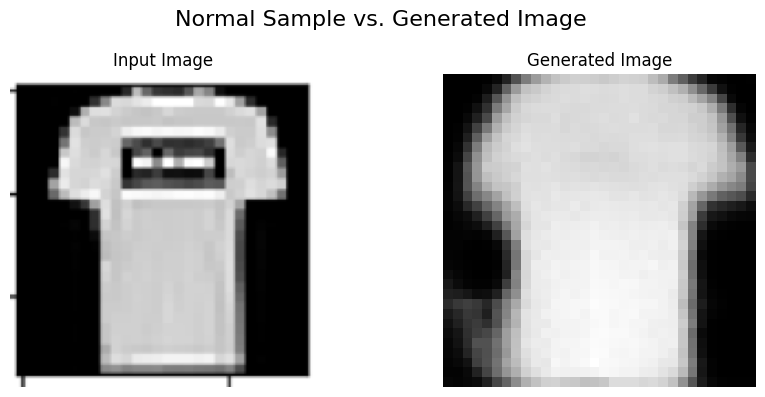

Anomal Class

Reconstruction error: tensor([0.6969], grad_fn=<MeanBackward1>)


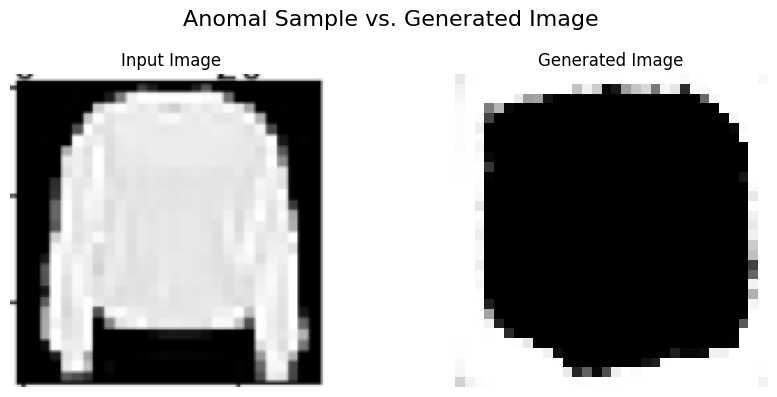

In [ ]:
model2 = GAN_SOTA()
model2.load_state_dict(torch.load("./GAN_pretrained"))

input_image_path = '0.png'     # t-shirt
#input_image_path = '1.png'     # trousers
#input_image_path = '4.png'     # coat
#input_image_path = '5.png'     # sandal
#input_image_path = '6.png'     # shirt
#input_image_path = '7.png'     # Sneaker
#input_image_path = '8.png'     # bag

compare_img(input_image_path, model2, "Normal Sample")

print("Anomal Class")
input_image_path = '6.png'
compare_img(input_image_path, model2, "Anomal Sample")

# Conclusions
The GAN-based model, as expected, acquired the highest performances